# 导入所需的库

- 标准库：
  - heapq: 堆数据结构
  - collections：容器
  - struct：c风格结构体二进制包装与操作
- 第三方库：
  - PIL：图片读取和处理
  - numpy：数学计算
  - pywt: PyWavelets 小波工具包
  - cv2: OpenCV 视觉工具包
- 自定义库：
  - utils：工具库

In [217]:
import heapq
from collections import Counter
import struct
from PIL import Image
import numpy as np
import pywt
import cv2

import utils

In [218]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

定义常量：

- BYTE_LENGTH: 一个字节的长度，4

In [219]:
BYTE_LENGTH = 4
Q_FACTOR = 20

# 一、JPEG2000 编码流程

## 1.1 图像分块 (Tiling)

    输入图像首先被分割成若干个大小一致的矩形块，称为Tiles。这使得可以独立地处理和压缩图像的每一个部分，有利于并行处理和区域解码。

注意：

> PIL.Image.Image 的 size 属性获取的是 (w, h)
> np.ndarray 的 shape 属性获取的是 (h, w, c)

In [220]:
def tile_pil_image(image, tile_size):
    """
    将图像分割成指定大小的块
    :param image: 输入图像，PIL.Image.Image对象
    :param tile_size: 块大小(w, h)，整数或元组
    :return: 图像块列表
    """
    tiles = []
    w, h = image.size

    if isinstance(tile_size, int):
        tile_size = utils.turn2pair(tile_size)
    
    tile_w, tile_h = tile_size

    for x in range(0, w, tile_w):
        for y in range(0, h, tile_h):
            box = (x, y, x+tile_w, y+tile_h)
            tile = image.crop(box)
            tiles.append(tile)
    return tiles

def tile_np_image(image, tile_size):
    """
    将图像分割成指定大小的块
    :param image: 输入图像，NumPy数组
    :param tile_size: 块大小(h, w)，整数或元组
    :return: 图像块列表
    """
    h, w = image.shape[:2]
    tiles = []
    
    if isinstance(tile_size, int):
        tile_size = utils.turn2pair(tile_size)
    
    tile_h, tile_w = tile_size
    
    # 遍历图像并提取块
    for x in range(0, w, tile_w):
        for y in range(0, h, tile_h):
            tile = image[y:y+tile_h, x:x+tile_w]
            tiles.append(tile)
    
    return tiles

In [221]:
image = Image.open('kodim01.png').convert('RGB')  # 读取灰度图像
tiles = tile_pil_image(image, 128)  # 将图像分割成128x128的块
print(f"行数：{768/128}, 列数：{512/128}")
print(f"原图大小：{image.size}")
print(f"图片分块后的块数：{len(tiles)}")
# for id, tile in enumerate(tiles):
#     print(f"第{id}块图块，大小为{tile.size}")

cv_img = cv2.imread('kodim01.png')
cv_tiles = tile_np_image(cv_img, 128)
print(f"行数：{768/128}, 列数：{512/128}")
print(f"原图大小：{cv_img.shape}")
print(f"图片分块后的块数：{len(cv_tiles)}")


行数：6.0, 列数：4.0
原图大小：(768, 512)
图片分块后的块数：24
行数：6.0, 列数：4.0
原图大小：(512, 768, 3)
图片分块后的块数：24


## 1.2 颜色变换 (Color Transform)

    对彩色图像进行颜色空间转换。通常将RGB颜色空间转换为YUV颜色空间，从而将颜色信息分成亮度和色度分量，有利于更高效的压缩。

  > 参考：[opencv与PIL互相转换](https://blog.csdn.net/weixin_50113231/article/details/123004037)

In [222]:
def convertColor2YUV(image):
    """
    颜色变换：从RGB转换到YUV
    :param image: 输入图像, PIL.Image.Image 或 np.ndarray
    :return: YUV图像 np.ndarray
    """
    yuv_img = None
    if isinstance(image, Image.Image):
        yuv_img = cv2.cvtColor(utils.pil2np(image), cv2.COLOR_RGB2YUV)
    else:
        yuv_img = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    return yuv_img

In [223]:
yuv_tiles = [convertColor2YUV(tile) for tile in tiles]
yuv_tiles[0].shape

(128, 128, 3)

## 1.3 离散小波变换 (Discrete Wavelet Transform, DWT)

    对每个图像块进行离散小波变换，将图像信息分解到不同的频带（子带）中。DWT有助于更有效地表示图像数据，尤其是高频细节部分。

In [224]:
def discrete_wavelet_transform_2d(image: np.ndarray):
    """
    对图像块进行离散小波变换
    :param image: 图像块（2D）
    :return: 小波变换系数
    """
    coeffs = pywt.dwt2(image, 'haar')
    return coeffs

In [225]:
# 示例DWT
# 3d的返回值：([128, 64, 2], ([128, 64, 2], [128, 64, 2], [128, 64, 2]))
coeffs_3d = discrete_wavelet_transform_2d(yuv_tiles[0])
# 2d的返回值：([64, 64], ([64, 64], [64, 64], [64, 64]))
coeffs_2d = discrete_wavelet_transform_2d(yuv_tiles[0][:, :, 0])
coeffs_2d[0].shape, coeffs_2d[1][0].shape, coeffs_2d[1][1].shape, coeffs_2d[1][2].shape
# utils.np2pil(coeffs[0], cv2.COLOR_YUV2RGB)

((64, 64), (64, 64), (64, 64), (64, 64))

## 1.4 量化 (Quantization)

    对小波变换后的系数进行量化，减少数据的精度以降低信息量。量化是一个有损压缩步骤，通过减少不重要的系数值来实现压缩。

In [226]:
def quantize(coeffs, q_factor):
    """
    对小波系数进行量化
    :param coeffs: 小波系数
    :param q_factor: 量化因子
    :return: 量化后的系数
    """
    cA, (cH, cV, cD) = coeffs
    cA = np.round(cA / q_factor)
    cH = np.round(cH / q_factor)
    cV = np.round(cV / q_factor)
    cD = np.round(cD / q_factor)
    return cA, (cH, cV, cD)

In [227]:
quantized_coeffs = quantize(coeffs_2d, 10)
# 量化后，形状不变：([64, 64], ([64, 64], [64, 64], [64, 64]))
f"[{quantized_coeffs[0].shape}, [{quantized_coeffs[1][0].shape}, {quantized_coeffs[1][1].shape}, {quantized_coeffs[1][2].shape}]]"

'[(64, 64), [(64, 64), (64, 64), (64, 64)]]'

## 1.5 熵编码 (Entropy Coding)

    使用算术编码或EBCOT (Embedded Block Coding with Optimal Truncation) 对量化后的系数进行熵编码。EBCOT是一种先进的编码方法，能够自适应地对数据进行压缩并提供渐进式解码功能。

In [228]:
def huffman_encoding(data):
    """
    霍夫曼编码
    :param data: 输入数据
    :return: 编码后的数据和霍夫曼树
    """
    frequency = Counter(data)
    heap = [[weight, [symbol, ""]] for symbol, weight in frequency.items()]
    heapq.heapify(heap)
    
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    
    huffman_tree = sorted(heapq.heappop(heap)[1:], key=lambda p: (len(p[-1]), p))
    huffman_dict = {symbol: code for symbol, code in huffman_tree}
    encoded_data = "".join(huffman_dict[symbol] for symbol in data)
    
    return encoded_data, huffman_tree

def serialize_huffman_tree(huffman_tree):
    """
    序列化霍夫曼树以便存储
    :param huffman_tree: 霍夫曼树
    :return: 序列化的霍夫曼树
    """
    serialized_tree = []
    for symbol, code in huffman_tree:
        serialized_tree.append((symbol, code))
    return serialized_tree

In [229]:
data = np.ravel(quantized_coeffs[0])  # 示例数据
encoded_data, huffman_dict = huffman_encoding(data)
len(huffman_dict), len(encoded_data)

serialized_tree = serialize_huffman_tree(huffman_dict)
len(serialized_tree)
# serialized_tree

(32, 18647)

32

## 1.6 码流组织 (Bitstream Organization)

    将编码后的数据组织成一个压缩码流，包含图像块的头信息、量化参数、熵编码数据等。这些数据可以按需分层和分级，以支持不同分辨率和质量的解码。

In [230]:
def organize_bitstream(blocks, q_factor):
    """
    组织码流
    :param blocks: 图像块列表
    :param q_factor: 量化因子
    :return: 码流
    """
    bitstream = bytearray()
    huffman_trees = []

    for block in blocks:
        # 对每个通道进行小波变换和量化
        for channel in range(block.shape[2]):
            coeffs = discrete_wavelet_transform_2d(block[:,:,channel])
            quantized_coeffs = quantize(coeffs, q_factor)
            
            # 将量化后的系数写入码流
            cA, (cH, cV, cD) = quantized_coeffs
            flat_array = np.hstack((cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten())).astype(int)

            # 霍夫曼编码
            encoded_data, huffman_tree = huffman_encoding(flat_array)
            huffman_trees.append(huffman_tree)
            
            # 序列化霍夫曼树
            serialized_tree = serialize_huffman_tree(huffman_tree)

            # 将编码后的数据写入码流
            bitstream += struct.pack('I', len(encoded_data))
            # print(f"packed encoded_data length: {struct.pack('I', len(encoded_data))}")
            bitstream += encoded_data.encode('utf-8')
            # print(f"packed encoded_data: {encoded_data.encode('utf-8')[:20]}")
            bitstream += struct.pack('I', len(serialized_tree))
            # print(f"packed serialized_tree length: {struct.pack('I', len(serialized_tree))}")
            for symbol, code in serialized_tree:
                bitstream += struct.pack('i', symbol)
                # print(f"packed symbol: {struct.pack('i', symbol)}") 
                bitstream += struct.pack('I', len(code))
                # print(f"packed code length: {struct.pack('I', len(code))}") 
                bitstream += code.encode('utf-8')
                # print(f"packed code: {code.encode('utf-8')[:20]}") 

    return bitstream, huffman_trees

def save_bitstream(file_path, bitstream):
    """
    将码流保存到文件
    :param file_path: 文件路径
    :param bitstream: 码流
    """
    with open(file_path, 'wb') as f:
        f.write(bitstream)

In [231]:
bitstream, huffman_trees = organize_bitstream(cv_tiles, 10)
file_path = "test.jp2"
save_bitstream(file_path, bitstream)
print(f"{file_path}文件已保存！")

test.jp2文件已保存！


## 1.7 编码流程整合

    将编码流程整合到一起实现图像编码。

In [232]:
from pathlib import Path

def encode_jpeg2000(image_path, save_path, q_factor=5, tile_size=128):
    img = cv2.imread(image_path)
    img = convertColor2YUV(img)
    tiles = tile_np_image(img, tile_size)
    bitstream, huffman_trees = organize_bitstream(tiles, q_factor)
    save_bitstream(save_path, bitstream)
    print(f"{file_path}文件已保存！文件大小为：{Path(file_path).stat().st_size/1024:,.2f}KB")
    print(f"{image_path}文件大小为：{Path(image_path).stat().st_size/1024:,.2f}KB")

In [233]:
encode_jpeg2000('kodim01.png', 'encoded_kodim01.jp2', q_factor=Q_FACTOR, tile_size=128)

test.jp2文件已保存！文件大小为：2,118.41KB
kodim01.png文件大小为：719.24KB


# 二、解码过程

## 2.1 码流解析 (Bitstream Parsing) 

    解码器首先解析压缩码流，提取图像块的头信息、量化参数、熵编码数据等。

## 2.2 熵解码 (Entropy Decoding) 

    对熵编码的数据进行解码，恢复量化后的小波系数。

In [234]:
def deserialize_huffman_tree(serialized_tree):
    """
    反序列化霍夫曼树
    :param serialized_tree: 序列化的霍夫曼树
    :return: 霍夫曼树
    """
    huffman_tree = []
    for symbol, code in serialized_tree:
        huffman_tree.append((symbol, code))
    return huffman_tree

def huffman_decoding(encoded_data, huffman_tree):
    """
    霍夫曼解码
    :param encoded_data: 编码后的数据
    :param huffman_tree: 霍夫曼树
    :return: 解码后的数据
    """
    huffman_dict = {code: symbol for symbol, code in huffman_tree}
    decoded_data = []
    code = ""
    for bit in encoded_data:
        code += bit
        if code in huffman_dict:
            decoded_data.append(huffman_dict[code])
            code = ""
    return decoded_data

In [235]:
def decode_bitstream(file_path):
    """
    解码码流
    :param file_path: 文件路径
    :return: 图像数据
    """
    with open(file_path, 'rb') as f:
        bitstream = f.read()
    
    offset = 0
    data_blocks = []
    while offset < len(bitstream):
        # 读取编码数据的长度
        encoded_length = struct.unpack_from('I', bitstream, offset)[0]
        offset += BYTE_LENGTH
        
        # 读取编码数据
        encoded_data = bitstream[offset:offset + encoded_length]
        encoded_data = encoded_data.decode('utf-8')
        offset += encoded_length

         # 读取霍夫曼树的长度
        huffman_tree_length = struct.unpack_from('I', bitstream, offset)[0]
        offset += BYTE_LENGTH
        
        # 读取霍夫曼树
        serialized_tree = []
        for _ in range(huffman_tree_length):
            symbol = struct.unpack_from('i', bitstream, offset)[0]
            offset += BYTE_LENGTH

            code_length = struct.unpack_from('I', bitstream, offset)[0]
            offset += BYTE_LENGTH

            code = bitstream[offset:offset + code_length]
            code = code.decode('utf-8')
            offset += code_length
            
            serialized_tree.append((symbol, code))
        
        # 反序列化霍夫曼树
        huffman_tree = deserialize_huffman_tree(serialized_tree)
        # 霍夫曼解码
        decoded_data = huffman_decoding(encoded_data, huffman_tree)

        # 将解码数据添加到块列表
        data_blocks.append(decoded_data)
    
    return data_blocks

In [236]:
data_blocks = decode_bitstream('test.jp2')
len(data_blocks)
type(data_blocks[0])
len(data_blocks[0])

72

list

16384

## 2.3 反量化 (Inverse Quantization)

    对量化后的小波系数进行反量化，恢复小波变换的系数值。

In [237]:
def inverse_quantize(quantized_coeffs, q_factor):
    """
    反量化小波系数
    :param quantized_coeffs: 量化后的系数
    :param q_factor: 量化因子
    :return: 反量化后的系数
    """
    cA, (cH, cV, cD) = quantized_coeffs
    cA = cA * q_factor
    cH = cH * q_factor
    cV = cV * q_factor
    cD = cD * q_factor
    return cA, (cH, cV, cD)

In [238]:
def inverse_quantize_from_block(block, tile_size, q_factor=5):
    half_size = int(tile_size / 2)
    fre_size = half_size**2
    cA = np.array(block[:fre_size]).reshape((half_size, half_size))
    cH = np.array(block[fre_size: fre_size*2]).reshape((half_size, half_size))
    cV = np.array(block[fre_size*2: fre_size*3]).reshape((half_size, half_size))
    cD = np.array(block[fre_size*3:]).reshape((half_size, half_size))
    return inverse_quantize((cA, (cH, cV, cD)), q_factor)

## 2.4 反离散小波变换 (Inverse Discrete Wavelet Transform, IDWT)

    对小波系数进行反离散小波变换，将数据从频域变换回空域，重建图像块的像素值。

In [239]:
def inverse_discrete_wavelet_transform(coeffs):
    """
    逆离散小波变换
    :param coeffs: 小波变换系数
    :return: 重建的图像块
    """
    return pywt.idwt2(coeffs, 'haar')

In [248]:
def get_tiles_from_data(data_blocks, tile_size, q_factor=5):
    """
    从数据块还原图像块
    :param blocks: 解码后的图像块
    :param tile_size: 分块大小
    :return: 原始的图像块列表
    """
    reconstruct_tiles = []
    channels = []
    for block in data_blocks:
        coeffs = inverse_quantize_from_block(block, tile_size, q_factor)
        single_channel = inverse_discrete_wavelet_transform(coeffs)
        channels.append(single_channel)
        if len(channels) == 3:
            reconstruct_tiles.append(np.stack(channels, axis=2))
            channels.clear()
    return reconstruct_tiles

In [249]:
tile_size = 128
reconstruct_tiles = get_tiles_from_data(data_blocks, tile_size, Q_FACTOR)
f"number: {len(reconstruct_tiles)}, size: {reconstruct_tiles[0].shape}"

'number: 24, size: (128, 128, 3)'

## 2.5 颜色反变换 (Color Inverse Transform)

    对重建的图像块进行颜色反变换，将YUV颜色空间转换回RGB颜色空间，恢复原始颜色信息。

In [242]:
def convertColor2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_YUV2RGB)

## 2.6 图像块重组 (Tile Assembly)

    将解码后的图像块重新组合，形成完整的解码图像。

In [243]:
def merge_image(tiles, tile_size, image_shape):
    """
    将图像块重新组合并显示
    :param tiles: 图像块列表
    :param tile_size: 块大小(w, h)，整数或元组
    :param image_shape: 原始图像的形状(w, h)
    """
    w, h = image_shape

    if isinstance(tile_size, int):
        tile_size = utils.turn2pair(tile_size)

    tile_h, tile_w = tile_size
    # 创建一个空白图像用于展示块
    reassembled_image = np.zeros((h, w, 3), dtype=np.uint8)
    
    # 重新组合图像块
    idx = 0
    for x in range(0, w, tile_w):
        for y in range(0, h, tile_h):
            reassembled_image[y:y+tile_h, x:x+tile_w] = tiles[idx]
            idx += 1
    return reassembled_image

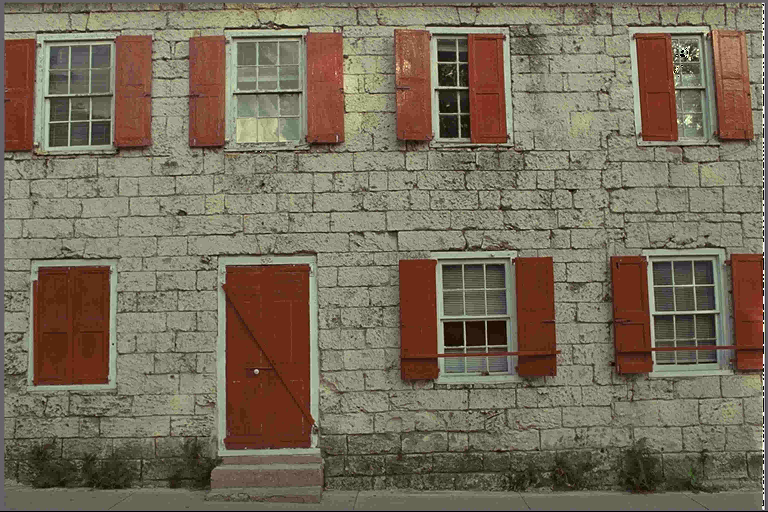

In [244]:
decode_img = merge_image(reconstruct_tiles, tile_size, image.size)
decode_img = convertColor2RGB(decode_img)
utils.np2pil(decode_img, None)
# utils.np2pil(decode_img, cv2.COLOR_BGR2RGB)

## 2.7 解码流程整合

    整合整个解码流程。

In [254]:
def decode_jpeg2000(input_bitstream_path, output_image_path, image_shape, tile_size=128, q_factor=1.0):
    # 解码码流
    decoded_blocks = decode_bitstream(input_bitstream_path)
    reconstruct_tiles = get_tiles_from_data(decoded_blocks, tile_size, q_factor)
    decode_img = merge_image(reconstruct_tiles, tile_size, image_shape)
    decode_img = convertColor2RGB(decode_img)
    decode_img = cv2.cvtColor(decode_img, cv2.COLOR_BGR2RGB)
    # 保存重建的图像
    cv2.imwrite(output_image_path, decode_img)
    print(f"解码后的图像已保存到 {output_image_path}")

In [255]:
decode_jpeg2000('encoded_kodim01.jp2', 'decode_kodim01.png', (768, 512), tile_size=128, q_factor=Q_FACTOR)

解码后的图像已保存到 decode_kodim01.png
